# Pix2Pix

In [1]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
from data_loader import DataLoader
import numpy as np
import os
import glob
import skimage
import imageio

/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/n/.pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class DataLoader():
    """
    .
    ├── README.md
    ├── datasets
    │   ├── test
    │   │   ├── source
    │   │   │   ├── 0.jpg
    │   │   │   └── 1.jpg
    │   │   └── target
    │   │       ├── 0.jpg
    │   │       └── 1.jpg
    │   └── train
    │       ├── source
    │       │   ├── 0.jpg
    │       │   ├── 1.jpg
    │       │   └── 2.jpg
    │       └── target
    │           ├── 0.jpg
    │           ├── 1.jpg
    │           └── 2.jpg
    ├── images
    └── pix2pix.ipynb
    
    """
    def __init__(self, dataset_path='datasets', img_res=(256, 256)):
        self.dataset_path = dataset_path
        self.img_res = img_res
        
    def _imread(self, path):
        return imageio.imread(path, as_gray=False, pilmode='RGB').astype(np.float)

    def load_data(self, batch_size=1, is_training=True):
        data_type = "train" if is_training else "test"
        source_paths_list = glob.glob('{}/{}/source/*'.format(self.dataset_path, data_type))
        target_paths_list = [path.replace('source', 'target') for path in source_paths_list]
        
        source_paths = np.array(source_paths_list)
        target_paths = np.array(source_paths_list)
        
        indexes = np.random.randint(len(source_paths), size=batch_size)
        
        source_batches = source_paths[indexes]
        target_batches = target_paths[indexes]
        
        imgs_source = []
        imgs_target = []
        
        for source_path, target_path in zip(source_batches, target_batches):
            img_source = self._imread(source_path)
            img_target = self._imread(target_path)

            img_source = skimage.transform.resize(img_source, self.img_res)
            img_target = skimage.transform.resize(img_target, self.img_res)

            # Do random horizontal flip on training
            if is_training and np.random.random() < 0.5:
                img_source = np.fliplr(img_source)
                img_target = np.fliplr(img_target)

            imgs_source.append(img_source)
            imgs_target.append(img_target)

        imgs_source = np.array(imgs_source) / 255
        imgs_target = np.array(imgs_target) / 255

        return imgs_source, imgs_target

    def generate_batch(self, batch_size=1, is_training=True):
        data_type = "train" if is_training else "test"
        source_paths_list = glob.glob('{}/{}/source/*'.format(self.dataset_path, data_type))
        target_paths_list = [path.replace('source', 'target') for path in source_paths_list]
        
        source_paths = np.array(source_paths_list)
        target_paths = np.array(source_paths_list)

        n_batches = len(source_paths) // batch_size

        while True:
            for i in range(n_batches):
                source_batch = source_paths[i * batch_size : (i + 1) * batch_size]
                target_batch = target_paths[i * batch_size : (i + 1) * batch_size]
                imgs_source, imgs_target = [], []
                for source_path, target_path in zip(source_batch, target_batch):
                    img_source = self._imread(source_path)
                    img_target = self._imread(target_path)

                    img_source = skimage.transform.resize(img_source, self.img_res)
                    img_target = skimage.transform.resize(img_target, self.img_res)

                    if is_training and np.random.random() > 0.5:
                        img_source = np.fliplr(img_source)
                        img_target = np.fliplr(img_source)

                    imgs_source.append(img_source)
                    imgs_target.append(img_target)

                imgs_source = np.array(imgs_source) / 255
                imgs_target = np.array(imgs_target) / 255

                yield imgs_source, imgs_target

In [6]:
class Pix2Pix():
    def __init__(self):
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'facades'
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))


        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generator
        #-------------------------

        # Build the generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # By conditioning on B generate a fake version of A
        fake_A = self.generator(img_B)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # Discriminators determines validity of translated images / condition pairs
        valid = self.discriminator([fake_A, img_B])

        self.combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
        self.combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)

    def build_generator(self):
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(d0, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        d7 = conv2d(d6, self.gf*8)

        # Upsampling
        u1 = deconv2d(d7, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        u7 = UpSampling2D(size=2)(u6)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

        return Model(d0, output_img)

    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([img_A, img_B])

        d1 = d_layer(combined_imgs, self.df, bn=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model([img_A, img_B], validity)

    def train(self, epochs, batch_size=1, sample_interval=50):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Condition on B and generate a translated version
                fake_A = self.generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = self.discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # -----------------
                #  Train Generator
                # -----------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time
                # Plot the progress
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        batch_i, self.data_loader.n_batches,
                                                                        d_loss[0], 100*d_loss[1],
                                                                        g_loss[0],
                                                                        elapsed_time))

                # If at save interval => save generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

    def sample_images(self, epoch, batch_i):
        os.makedirs('images/%s' % self.dataset_name, exist_ok=True)
        r, c = 3, 3

        imgs_A, imgs_B = self.data_loader.load_data(batch_size=3, is_testing=True)
        fake_A = self.generator.predict(imgs_B)

        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Condition', 'Generated', 'Original']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.close()


if __name__ == '__main__':
    gan = Pix2Pix()
    gan.train(epochs=200, batch_size=1, sample_interval=200)

In [7]:
pix2pix = Pix2Pix()
pix2pix.generator.summary()
pix2pix.discriminator.summary()
pix2pix.combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 64) 3136        input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_16 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 64, 64, 128)  131200      leaky_re_lu_16[0][0]             
__________________________________________________________________________________________________
leaky_re_l

/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [8]:
data_generator = DataLoader(dataset_path='./datasets', img_res=(256, 256))
pix2pix.train(epochs=30,
              gen_train_data=data_generator.generate_batch(batch_size=1),
              batch_size=1,
              train_steps=3,
              test_steps=3,
              savefig_epoch_interval=2,
              gen_test_data=data_generator.generate_batch(batch_size=1, is_training=False),
              load_data=data_generator.load_data
             )

/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/n/.pyenv/versions/3.6.1/envs/ssd/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 1/30] [D loss: 10.6, acc: 18.6%] [G loss: 63.1] time:0:0.36689636666666664
[Epoch 2/30] [D loss: 7.8, acc: 25.1%] [G loss: 31.7] time:0:0.6425304166666667
[Epoch 3/30] [D loss: 4.83, acc: 24.5%] [G loss: 17.5] time:0:0.9134282333333333
[Epoch 4/30] [D loss: 0.84, acc: 54.0%] [G loss: 34] time:0:1.1452397333333333
[Epoch 5/30] [D loss: 0.276, acc: 71.5%] [G loss: 25.6] time:0:1.4189897333333334
[Epoch 6/30] [D loss: 0.21, acc: 77.5%] [G loss: 26.6] time:0:1.64643995
[Epoch 7/30] [D loss: 0.416, acc: 66.3%] [G loss: 69.4] time:0:1.9197473666666667
[Epoch 8/30] [D loss: 0.524, acc: 61.5%] [G loss: 57.1] time:0:2.1526652833333335
[Epoch 9/30] [D loss: 0.427, acc: 64.1%] [G loss: 49.3] time:0:2.4215071166666666
[Epoch 10/30] [D loss: 3.64, acc: 57.8%] [G loss: 61.3] time:0:2.6590558
[Epoch 11/30] [D loss: 1.15, acc: 52.1%] [G loss: 56.5] time:0:2.9228746833333332
[Epoch 12/30] [D loss: 0.195, acc: 77.5%] [G loss: 41.9] time:0:3.1476740333333333
[Epoch 13/30] [D loss: 0.162, acc: 83.5

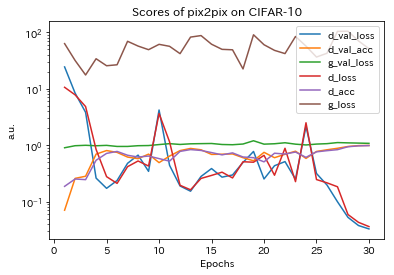

In [11]:
# --------
# Plot generator and discriminator accuracy and loss all
# --------
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = [i + 1 for i in range(30)]
plt.plot(x, pix2pix.d_val_losses, label="d_val_loss")
plt.plot(x, pix2pix.d_val_accs,   label="d_val_acc")
plt.plot(x, pix2pix.g_val_losses, label="g_val_loss")
plt.plot(x, pix2pix.d_losses,     label='d_loss')
plt.plot(x, pix2pix.d_accs,       label="d_acc")
plt.plot(x, pix2pix.g_losses,     label="g_loss")
plt.xlabel('Epochs')
plt.ylabel('a.u.')
plt.legend()
plt.yscale('log')
plt.title('Scores of pix2pix on CIFAR-10')
plt.show()